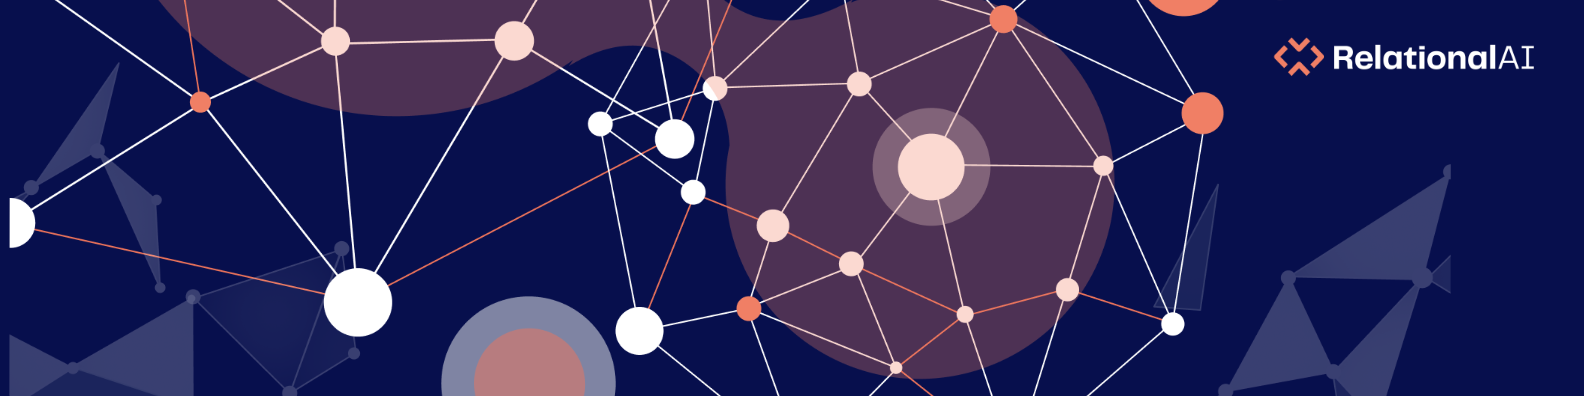

# Eigenvector Centrality

`Eigenvector Centrality` measures a node’s importance in such a way that connections to more important nodes contribute more to a node’s score than connections to less important nodes. It is computed based on the eigenvector associated with the top eigenvalue of the graph’s adjacency matrix.

We will look at a small example of a social graph, where people are friends which each other, and use eigenvector centrality to identify the most important nodes.

First, we need to import the `relationalai` library and define our model, which we call `MyEVGraph`. We also create one type in our model called `Person`.


In [ ]:
%pip install relationalai

In [2]:
import relationalai as rai
from relationalai.std.graphs import Graph
from relationalai.std import aggregates
from relationalai.std import alias
import colorsys

model = rai.Model("MyEVGraph")
Person = model.Type("Person")

## Let's add some data to our model
We define our data as a list of people who are friends with each other. We then use it in a rule to populate our model.

Rules describe objects in our model and relationships between them. They are created using the `model.rule()` context manager.

This rule creates objects of the `Person` type with a `name` property and also sets a `friends_with` property that we use to connect the various nodes in our graph. 

In [3]:
data = [
    ("Mary", "Bob"),
    ("Bob", "Frank"),
    ("Frank", "Erica"),
    ("Jessy", "Tom"),
    ("Jessy", "Ed"),
    ("Jessy", "Bob"),
    ("Jessy", "Frank"),
    ("Jessy", "Mary"),
    ("Erica", "Jessy"),
    ("Tom", "Erica"),
    ("Tom", "Ed"),
    ("Ed", "Erica"),
]

with model.rule(dynamic = True):
    for (person_name, friend_name) in data:
        person = Person.add(name = person_name)
        friend = Person.add(name = friend_name)
        person.friends_with.add(friend)
        friend.friends_with.add(person)

## Creating the graph

Let's start by creating a `graph` with `nodes` and `edges`. We add all `Person` instances as nodes, and assign the `name` property so that we can use them in our queries and for visualization purposes. The `friends_with` property is then used to form the edges in our graph.

In [4]:
# Create graph
graph = Graph(model, undirected = True)
Nodes, Edges = graph.Node, graph.Edge

# add all Person instances as Nodes, assign `name` property (for displaying)
Nodes.extend(Person, name = Person.name)

# add all `friends_with` properties as Edges 
Edges.extend(Person.friends_with)

## Running the algorithm

To compute the Eigenvector Centrality of each node in the graph, we use the `eigenvector_centrality` function. We define a rule, that runs the algorithm and then sets the result as a `evc_score` property to each `Person` node.

In [5]:
with model.rule():
    p = Person()
    evc_score = graph.compute.eigenvector_centrality(p)
    p.set(evc_score = evc_score)
    Nodes(p).set(evc_score = evc_score)

## Querying the Graph
Graph Nodes, Edges and their properties are queried using `model.query()` context and `graph.Node()` or `graph.Edge()` types.

Alternatively, the entire graph representation can be fetched using `Graph(model).fetch()`. This returns a dictionary with two keys, `nodes` and `edges`, that represents the entire graph. 

We are also using `rank_desc` function to order people depending on the scores. 

In [6]:
with model.query() as select:
    p = Person()
    order = aggregates.rank_desc(p.evc_score)
    response = select(alias(order,'rank'), p.name, p.evc_score)
    
response

### Let's find out who are friends with the second highest score

In [7]:
# For the person that has the second highest score, get the names and scores of their friends
with model.query() as select:
    p = Person()
    aggregates.rank_desc(p.evc_score) == 2
    friends = p.friends_with
    response = select(friends.name, friends.evc_score)
    
response

## Visualizing the results

As a final step, let's visualize our results for better understanding. `Graph(model).visualize()` is used for that purpose. We are setting the nodes color and size depending on their Eigenvector Centrality score.

In [8]:
def get_gradient_color(value):
    rgb = colorsys.hsv_to_rgb(1, value * 1.4, 1) # Adjust the value multiplier to control the gradient range
    return '#{:02x}{:02x}{:02x}'.format(int(rgb[0] * 255), int(rgb[1] * 255), int(rgb[2] * 255))

graph.visualize(three = False, style = {
    "node": {
        "color": lambda n: get_gradient_color(n["evc_score"]),
        "label": lambda n: n['name'],
        "size": lambda n: n['evc_score'] * 100
    },
    "edge": {
        "color": "green"
    }
}).display(inline = True)